# Dataset A – Adult Income
## Exploratory Data Analysis (EDA)

We want to understand the structure, target distribution, and key properties of the Adult Income dataset in order to formulate hypothesis-driven expectations about algorithmic performance.

In [1]:
import os

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import StratifiedKFold, learning_curve, cross_validate
from sklearn.metrics import confusion_matrix


SEED=49
np.random.seed(SEED)
random.seed(SEED)

### Data Loading

We load the Adult Income dataset and inspect its basic structure.

In [3]:
DATA_PATH = "../adult.csv"
df = pd.read_csv(DATA_PATH)

df.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K
4,34.0,Private,198693.0,10th,6.0,Never-married,Other-service,Not-in-family,White,Male,0.0,0.0,30.0,United-States,<=50K


If we look closely, `education` and `education-num` are redundant because they contain the same information, expressed in two different ways. For the purposes of creating the model, it would be best to omit one of them. We have decided to omit `education`, since `education-num` is a variable that is already numerical, which although it refers to categories, since there are many categories it will be better to treat it as numerical. 

The feature `fnlwgt` represents a census sampling weight rather than an individual-level attribute. Since our goal is predictive modeling at the individual level, this variable does not carry meaningful explanatory information and is excluded from the feature set.

### Dataset Overview

We examine dataset size, feature types, and missing values.

In [4]:
df.shape

(45222, 15)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             45222 non-null  float64
 1   workclass       45222 non-null  object 
 2   fnlwgt          45222 non-null  float64
 3   education       45222 non-null  object 
 4   education-num   45222 non-null  float64
 5   marital-status  45222 non-null  object 
 6   occupation      45222 non-null  object 
 7   relationship    45222 non-null  object 
 8   race            45222 non-null  object 
 9   sex             45222 non-null  object 
 10  capital-gain    45222 non-null  float64
 11  capital-loss    45222 non-null  float64
 12  hours-per-week  45222 non-null  float64
 13  native-country  45222 non-null  object 
 14  class           45222 non-null  object 
dtypes: float64(6), object(9)
memory usage: 5.2+ MB


In [6]:
df.isna().sum().sort_values(ascending=False)

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
class             0
dtype: int64

### Target Variable Distribution

We analyze class balance to motivate metric selection.

In [7]:
target_col = "class"
df[target_col].value_counts()

<=50K    34014
>50K     11208
Name: class, dtype: int64

In [8]:
df[target_col].value_counts(normalize=True)

<=50K    0.752156
>50K     0.247844
Name: class, dtype: float64

### Attributes Distribution

We analyze them to see if they can really add value to the analysis

In [9]:
df[["age", "hours-per-week", "capital-gain", "capital-loss"]].describe()

,age,hours-per-week,capital-gain,capital-loss
count,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,40.938017,1101.430344,88.595418
std,13.217870,12.007508,7506.430084,404.956092
min,17.000000,1.000000,0.000000,0.000000
25%,28.000000,40.000000,0.000000,0.000000
50%,37.000000,40.000000,0.000000,0.000000
75%,47.000000,45.000000,0.000000,0.000000
max,90.000000,99.000000,99999.000000,4356.000000


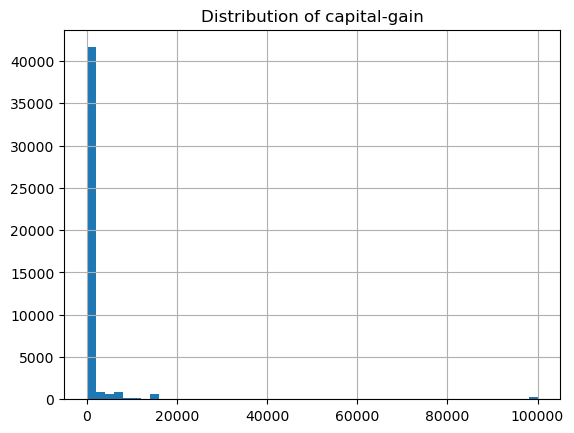

In [10]:
df["capital-gain"].hist(bins=50)
plt.title("Distribution of capital-gain")
plt.show()

In [11]:
categorical_cols = df.select_dtypes(include="object").columns.tolist()
categorical_cols.remove("class")

categorical_cols

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country']

In [12]:
def categorical_target_summary(df, col, target="class"):
    return (
        pd.crosstab(df[col], df[target], normalize="index")
        .sort_values(">50K", ascending=False)
    )

for col in categorical_cols:
    print(f"\n=== {col.upper()} ===")
    display(categorical_target_summary(df, col))



=== WORKCLASS ===


class,<=50K,>50K
workclass,,
Self-emp-inc,0.445930,0.554070
Federal-gov,0.609531,0.390469
Local-gov,0.704839,0.295161
Self-emp-not-inc,0.721022,0.278978
State-gov,0.732785,0.267215
Private,0.782298,0.217702
Without-pay,0.904762,0.095238



=== EDUCATION ===


class,<=50K,>50K
education,,
Prof-school,0.245860,0.754140
Doctorate,0.266544,0.733456
Masters,0.445903,0.554097
Bachelors,0.580185,0.419815
Assoc-acdm,0.735899,0.264101
Assoc-voc,0.742726,0.257274
Some-college,0.798970,0.201030
HS-grad,0.836569,0.163431
12th,0.925477,0.074523



=== MARITAL-STATUS ===


class,<=50K,>50K
marital-status,,
Married-civ-spouse,0.545761,0.454239
Married-AF-spouse,0.562500,0.437500
Divorced,0.895982,0.104018
Married-spouse-absent,0.902174,0.097826
Widowed,0.905247,0.094753
Separated,0.929837,0.070163
Never-married,0.951980,0.048020



=== OCCUPATION ===


class,<=50K,>50K
occupation,,
Exec-managerial,0.520889,0.479111
Prof-specialty,0.549933,0.450067
Protective-serv,0.685451,0.314549
Tech-support,0.710563,0.289437
Armed-Forces,0.714286,0.285714
Sales,0.730954,0.269046
Craft-repair,0.774917,0.225083
Transport-moving,0.793610,0.206390
Adm-clerical,0.863538,0.136462



=== RELATIONSHIP ===


class,<=50K,>50K
relationship,,
Wife,0.514108,0.485892
Husband,0.544252,0.455748
Not-in-family,0.895061,0.104939
Unmarried,0.936926,0.063074
Other-relative,0.962936,0.037064
Own-child,0.984153,0.015847



=== RACE ===


class,<=50K,>50K
race,,
Asian-Pac-Islander,0.716807,0.283193
White,0.737629,0.262371
Other,0.872521,0.127479
Black,0.873699,0.126301
Amer-Indian-Eskimo,0.878161,0.121839



=== SEX ===


class,<=50K,>50K
sex,,
Male,0.687523,0.312477
Female,0.886424,0.113576



=== NATIVE-COUNTRY ===


class,<=50K,>50K
native-country,,
Taiwan,0.545455,0.454545
France,0.555556,0.444444
India,0.578231,0.421769
England,0.605042,0.394958
Iran,0.607143,0.392857
Canada,0.631902,0.368098
Greece,0.632653,0.367347
Japan,0.651685,0.348315
Yugoslavia,0.652174,0.347826


### Initial Observations

- The dataset contains 45222 observations and shows no missing values across features.
- The target variable is clearly imbalanced, with approximately a 3:1 ratio between the ≤50K and >50K classes (34014 vs. 11208 observations).
- This level of imbalance suggests that accuracy alone may be misleading. Therefore, F1-score and precision/recall based metrics are more appropriate for evaluation.
- The feature set is heterogeneous, combining continuous variables (such as age, hours-per-week, capital-gain/loss) with multiple categorical variables (such as education, occupation, marital-status).
- Several categorical features appear to have high cardinality, which may increase effective dimensionality after encoding and impact distance-based methods.
- Some continuous variables (notably capital-gain and capital-loss) appear to be highly skewed, with many zero values and a small number of large non-zero entries.


### Preliminary Hypothesis

Based on the observed sparsity, high dimensionality, and class imbalance, we hypothesize that:

- Linear models (e.g., linear SVM) will perform competitively due to margin maximization in sparse spaces.
- kNN performance may degrade due to the curse of dimensionality.
- Tree-based models may overfit without strong regularization.

## Experiments


In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

X = df.drop(columns=["class", "fnlwgt", "education"])
y = df["class"]

num_cols = ["age", "hours-per-week", "capital-gain", "capital-loss", 'education-num']
cat_cols = ['workclass','marital-status','occupation','relationship','race','sex','native-country']

preprocessor = ColumnTransformer(
    [
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

preprocessor_knn = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), cat_cols),
    ],
    remainder="drop"
)

80% training set, 20% testing set

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

y_bin = (pd.Series(y).astype(str).str.strip() == ">50K").astype(int)

y = y_bin


## Leakage / Evaluation Sanity Check

We evaluate a most-frequent dummy classifier to confirm that the evaluation setup is leakage-safe to contextualize accuracy under class imbalance (∼3:1).

In [15]:
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score

dummy = Pipeline([
    ("prep", preprocessor),
    ("clf", DummyClassifier(strategy="most_frequent", random_state=42))
])

dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)

print("Dummy Accuracy:", accuracy_score(y_test, y_pred_dummy))
print("Dummy F1:", f1_score(y_test, y_pred_dummy, pos_label=">50K"))

Dummy Accuracy: 0.7521282476506357
Dummy F1: 0.0


In [16]:
import time

def runtime_fit_predict(model, X_train, y_train, X_test, repeats=3):
    """
    Measure average training and inference time for a givel model (sklearn)
    
    Input:
        model (sklearn estimator): model supporting fit and prediction
        X_train (array): training feature vector
        y_train (array): training target vector
        X_test (array): test feature matrix
        repeats (int): number of repeated measurements to average runtime
    Return:
        fit_times (float): mean training time in seconds
        pred_times (float): mean prediciton time in seconds
    """
    fit_times = []
    pred_times = []
    for _ in range(repeats):
        t0 = time.perf_counter()
        model.fit(X_train, y_train)
        t1 = time.perf_counter()
        _ = model.predict(X_test)
        t2 = time.perf_counter()
        fit_times.append(t1 - t0)
        pred_times.append(t2 - t1)
    return float(np.mean(fit_times)), float(np.mean(pred_times))

def build_runtime_table(models_dict, X_train, y_train, X_test, repeats=3):
    """
    Build the comparison table abour runtime for the given models (sklearn)
    
    Input:
        model_dict (dict): dictionary mapping the name of the model with the sklearn model
        X_train (array): training feature vector
        y_train (array): training target vector
        X_test (array): test feature matrix
        repeats (int): number of repeated measurements to average runtime
    Return: pd.dataframe: table with the results
    """
    rows = []
    for name, model in models_dict.items():
        fit_t, pred_t = runtime_fit_predict(model, X_train, y_train, X_test, repeats=repeats)
        rows.append({"model": name, "fit_s": fit_t, "predict_s": pred_t})
    return pd.DataFrame(rows).sort_values("fit_s")


def torch_runtime_train_predict(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    """
    Measure average training and inference time for a PyTorch neural network model
    
    Input:
        model (torch.nn.Module): neural network model 
        train_loader (DataLoader): DataLoader providing training batches
        test_loader (DataLoader): DataLoader providing test batches for inference
        criterion (torch loss): loss function 
        optimizer (torch optimizer): optimizer used for parameter updates
        epochs (int): number of training epochs
    Return:
        fit_times (float): total training time in seconds
        pred_times (float): total prediciton time in seconds
    """
    t0 = time.perf_counter()
    for _ in range(epochs):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()
    t1 = time.perf_counter()

    model.eval()
    t2 = time.perf_counter()
    with torch.no_grad():
        for xb, _ in test_loader:
            _ = model(xb)
    t3 = time.perf_counter()

    return (t1 - t0), (t3 - t2)

Function to draw the learning curve

In [17]:
def plot_learning_curve(estimator, X, y, title, *, scoring="f1", cv_splits=5, train_sizes=np.linspace(0.1, 1.0, 8), n_jobs=-1, seed=49):
    """
    Plot a learning curve showing training and validation performance as a function of the training set  size using cross-validation (CV)
    
    Input:
        estimator: (sklearn estimator) model or pipeline to be evaluated
        X (array): feature matrix
        y (array): target vector
        title (str): title of the plot
        scoring (str): scoring metric used for evaluation
        cv_splits (int): number of stratified CV folds
        train_sizes (array): fractions of the training data used to generate the learning curve
        n_jobs (int): number of parallel jobs for CV
        seed (int): random seed for reproducibility
    Return: None
    """
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=seed)
    sizes, train_scores, val_scores = learning_curve(estimator, X, y, train_sizes=train_sizes,cv=cv,scoring=scoring, n_jobs=n_jobs)

    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)

    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel(scoring)

    plt.plot(sizes, train_mean, marker="o", label="train")
    plt.plot(sizes, val_mean, marker="o", label="validation")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Fucntions to draw the model complexity curve

In [18]:
from dataclasses import dataclass

@dataclass
class MCCurveResult:
    param_values: list
    mean_score: list

def model_complexity_curve(base_pipeline, X, y, param_name, param_values, *,scoring="f1", cv_splits=5, seed=49, n_jobs=-1):
    """
    Compute a model complexity curve by evaluating validation performance across diffrent values of a single  hyperparameter using CV
    
    Input:
        base_pipeline (sklearn pipeline): model or pipeline with preprocessing
        X (array): feature matrix
        y (array): target vector
        param_name (str): name of the hyperparameter to vary
        param_values (list): list of hyperparameter values to evaluate
        scoring (str): scoring metric used for evaluation
        cv_splits (int): number of stratified CV folds
        seed (int): random seed for reproducibility
        n_jobs (int): number of parallel jobs for CV
    Return: MCCurveResult: object containing hyperparameter values and mean validation scores
    """
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=seed)

    mean_score = []
    for v in param_values:
        est = base_pipeline.set_params(**{param_name: v})
        cv_res = cross_validate(est, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs)
        mean_score.append(float(np.mean(cv_res["test_score"])))

    return MCCurveResult(param_values=list(param_values), mean_score=mean_score)

def plot_mc_curve(res, title, xlabel, ylabel="F1"):
    """
    Plot a model complexity curve showing validation performance as a function of a single hyperparameter
    
    Input: 
        res (MCCurveResult): output from model_complexity_curve
        title (str): title of the plot
        xlabel (str): label for the x-axis (hyperparameter name)
        ylabel (str): label for the y-axis (performance metric)
    Return: None
    """
    
    x = np.arange(len(res.param_values))
    y = np.array(res.mean_score, dtype=float)
    labels = [str(v) for v in res.param_values]

    plt.figure()
    plt.plot(x, y, marker="o")
    plt.xticks(x, labels, rotation=30)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### Decision Tree

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, accuracy_score
import pandas as pd

np.random.seed(SEED)
random.seed(SEED)

# Pipeline
dt_pipe = Pipeline([
    ("prep", preprocessor),
    ("clf", DecisionTreeClassifier(random_state=SEED))
])

# Complexity curve: depth
param_grid = {
    "clf__max_depth": [2, 4, 6, 8, 12, 16, None]
}

f1_pos = make_scorer(f1_score, pos_label=">50K")

dt_grid = GridSearchCV(
    dt_pipe,
    param_grid,
    scoring=f1_pos,
    cv=5,
    n_jobs=-1
)

dt_grid.fit(X_train, y_train)

dt_best = dt_grid.best_estimator_

y_pred = dt_best.predict(X_test)

print("Best max_depth:", dt_grid.best_params_)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test F1 (>50K):", f1_score(y_test, y_pred, pos_label=">50K"))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Best max_depth: {'clf__max_depth': 12}
Test Accuracy: 0.8543946932006633
Test F1 (>50K): 0.6664978475563433
Confusion Matrix:
 [[6412  391]
 [ 926 1316]]


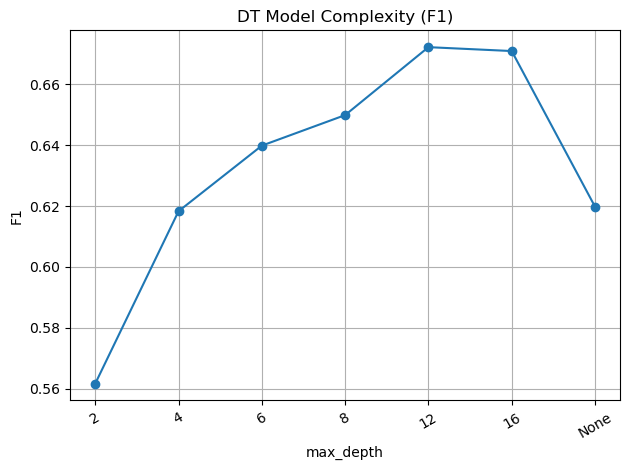

In [20]:
from sklearn.metrics import make_scorer, f1_score

f1_pos = make_scorer(f1_score, pos_label=">50K")

dt_mc = model_complexity_curve(
    base_pipeline=dt_pipe,
    X=X_train, y=y_train,
    param_name="clf__max_depth",
    param_values=[2, 4, 6, 8, 12, 16, None],
    scoring=f1_pos
)

plot_mc_curve(dt_mc, "DT Model Complexity (F1)", xlabel="max_depth")

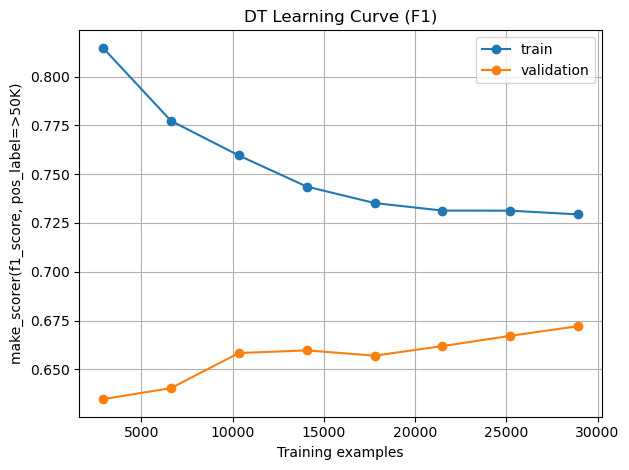

In [21]:
plot_learning_curve(dt_best, X_train, y_train, "DT Learning Curve (F1)", scoring=f1_pos)

### k-NN

In [22]:
from sklearn.neighbors import KNeighborsClassifier

np.random.seed(SEED)
random.seed(SEED)

knn_pipe = Pipeline([
    ("prep", preprocessor_knn),
    ("clf", KNeighborsClassifier())
])

param_grid = {
    "clf__n_neighbors": [3, 5, 7, 9, 11, 13, 15, 25, 50]
}

f1_pos = make_scorer(f1_score, pos_label=">50K")

knn_grid = GridSearchCV(
    knn_pipe,
    param_grid,
    scoring=f1_pos,
    cv=5,
    n_jobs=-1
)

knn_grid.fit(X_train, y_train)

knn_best = knn_grid.best_estimator_

y_pred_knn = knn_best.predict(X_test)

print("Best k:", knn_grid.best_params_)
print("Test Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Test F1 (>50K):", f1_score(y_test, y_pred_knn, pos_label=">50K"))

cm = confusion_matrix(y_test, y_pred_knn)
print("Confusion Matrix:\n", cm)

Best k: {'clf__n_neighbors': 11}
Test Accuracy: 0.8313985627418463
Test F1 (>50K): 0.6308399903171145
Confusion Matrix:
 [[6217  586]
 [ 939 1303]]


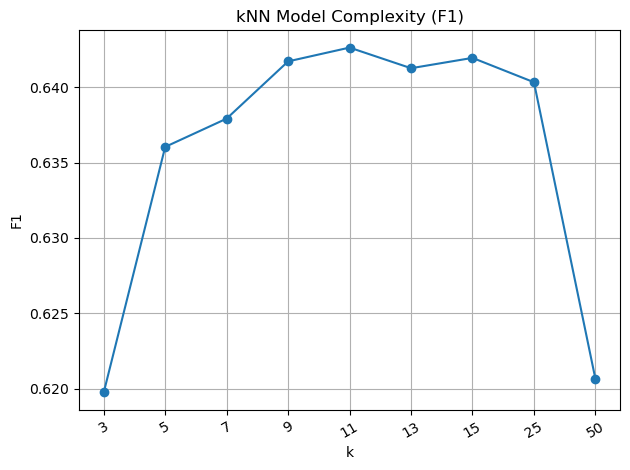

In [23]:
from sklearn.metrics import make_scorer, f1_score

f1_pos = make_scorer(f1_score, pos_label=">50K")

knn_mc = model_complexity_curve(
    base_pipeline=knn_pipe,
    X=X_train, y=y_train,
    param_name="clf__n_neighbors",
    param_values=[3, 5, 7, 9, 11, 13, 15, 25, 50],
    scoring=f1_pos
)

plot_mc_curve(knn_mc, "kNN Model Complexity (F1)", xlabel="k")

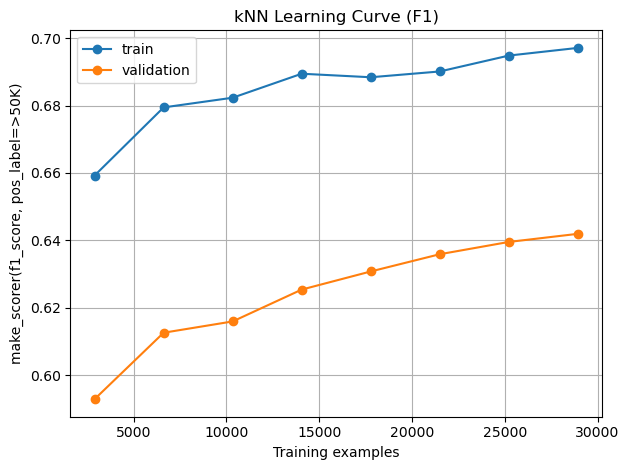

In [24]:
plot_learning_curve(knn_best, X_train, y_train, "kNN Learning Curve (F1)", scoring=f1_pos)

### SVM - Linear

In [25]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, accuracy_score

np.random.seed(SEED)
random.seed(SEED)

svm_lin_pipe = Pipeline([
    ("prep", preprocessor), 
    ("clf", LinearSVC(random_state=SEED, max_iter=10000))
])

param_grid = {
    "clf__C": [0.01, 0.1, 1, 10]
}

f1_pos = make_scorer(f1_score, pos_label=">50K")

svm_lin_grid = GridSearchCV(
    svm_lin_pipe,
    param_grid,
    scoring=f1_pos,
    cv=5,         
    n_jobs=-1
)

svm_lin_grid.fit(X_train, y_train)

svm_lin_best = svm_lin_grid.best_estimator_
y_pred_lin = svm_lin_best.predict(X_test)

print("Best params (Linear):", svm_lin_grid.best_params_)
print("Test Accuracy:", accuracy_score(y_test, y_pred_lin))
print("Test F1 (>50K):", f1_score(y_test, y_pred_lin, pos_label=">50K"))

cm = confusion_matrix(y_test, y_pred_lin)
print("Confusion Matrix:\n", cm)

/Users/juancarloshenriquez/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/juancarloshenriquez/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/juancarloshenriquez/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/juancarloshenriquez/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/juancarloshenriquez/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best params (Linear): {'clf__C': 0.1}
Test Accuracy: 0.8468767274737424
Test F1 (>50K): 0.6581091088620094
Confusion Matrix:
 [[6327  476]
 [ 909 1333]]


/Users/juancarloshenriquez/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/juancarloshenriquez/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/juancarloshenriquez/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/juancarloshenriquez/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/juancarloshenriquez/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


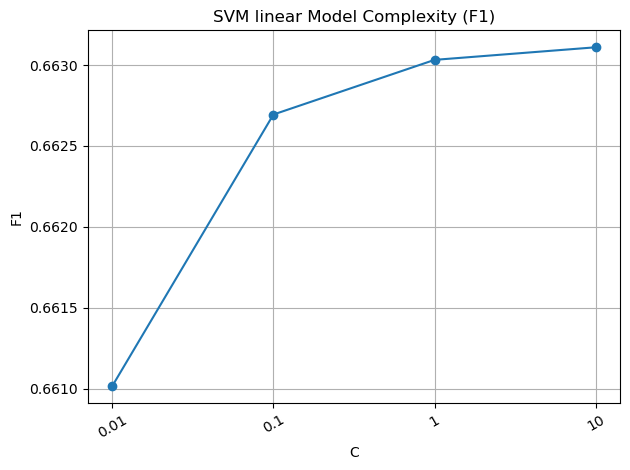

In [26]:
from sklearn.metrics import make_scorer, f1_score

f1_pos = make_scorer(f1_score, pos_label=">50K")

svm_lin_mc = model_complexity_curve(
    base_pipeline=svm_lin_pipe,
    X=X_train, y=y_train,
    param_name="clf__C",
    param_values=[0.01, 0.1, 1, 10],
    scoring=f1_pos
)

plot_mc_curve(svm_lin_mc, "SVM linear Model Complexity (F1)", xlabel="C")

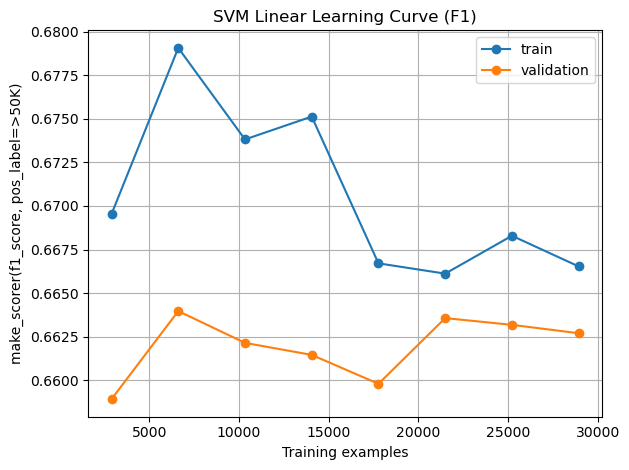

In [27]:
plot_learning_curve(svm_lin_best, X_train, y_train, "SVM Linear Learning Curve (F1)", scoring=f1_pos)

### SVM - RBF

Kernelized SVMs with RBF kernels incur quadratic-to-cubic training complexity with respect to the number of training examples, which makes full cross-validation on the complete Adult dataset computationally prohibitive. To enable tractable hyperparameter tuning while preserving evaluation integrity, we perform model selection for the RBF kernel on a stratified subset (40%) of the training data only. All final evaluations are conducted on a shared held-out test set, ensuring fair comparison across models. 

In [28]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score, accuracy_score

np.random.seed(SEED)
random.seed(SEED)

# Stratified subsample only of the training
SUBSAMPLE_FRAC = 0.4 

sss = StratifiedShuffleSplit(
    n_splits=1,
    test_size=1 - SUBSAMPLE_FRAC,
    random_state=SEED
)

idx_small, _ = next(sss.split(X_train, y_train))
X_train_small = X_train.iloc[idx_small]
y_train_small = y_train.iloc[idx_small]

svm_rbf_pipe = Pipeline([
    ("prep", preprocessor),
    ("clf", SVC(kernel="rbf"))
])


param_grid = {
    "clf__C": [0.1, 1, 10],
    "clf__gamma": ["scale", 0.01, 0.1]
}


f1_pos = make_scorer(f1_score, pos_label=">50K")


svm_rbf_grid = GridSearchCV(
    svm_rbf_pipe,
    param_grid,
    scoring=f1_pos,
    cv=5,
    n_jobs=-1
)

svm_rbf_grid.fit(X_train_small, y_train_small)

svm_rbf_best = svm_rbf_grid.best_estimator_

y_pred_svm = svm_rbf_best.predict(X_test)

print("Best params (RBF):", svm_rbf_grid.best_params_)
print("Test Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Test F1 (>50K):", f1_score(y_test, y_pred_svm, pos_label=">50K"))

cm = confusion_matrix(y_test, y_pred_svm)
print("Confusion Matrix:\n", cm)

Best params (RBF): {'clf__C': 1, 'clf__gamma': 0.1}
Test Accuracy: 0.8487562189054726
Test F1 (>50K): 0.6557624559637644
Confusion Matrix:
 [[6374  429]
 [ 939 1303]]


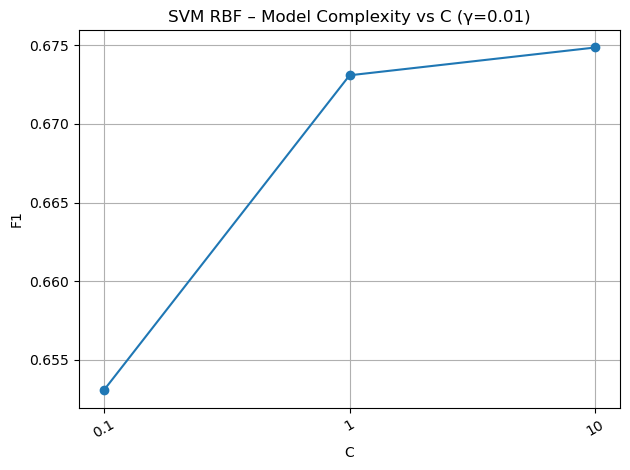

In [29]:
svm_rbf_fixed_gamma = svm_rbf_pipe.set_params(clf__gamma=0.1)

f1_pos = make_scorer(f1_score, pos_label=">50K")

svm_rbf_C_mc = model_complexity_curve(
    base_pipeline=svm_rbf_fixed_gamma,
    X=X_train,
    y=y_train,
    param_name="clf__C",
    param_values=[0.1, 1, 10],
    scoring=f1_pos
)

plot_mc_curve(svm_rbf_C_mc, title="SVM RBF – Model Complexity vs C (γ=0.01)", xlabel="C")

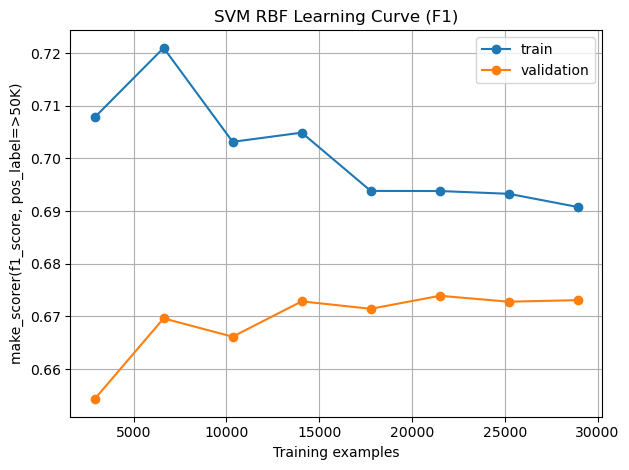

In [30]:
plot_learning_curve(svm_rbf_best, X_train, y_train, "SVM RBF Learning Curve (F1)", scoring=f1_pos)

### Neural Network

#### sklearn MLPClassifier

In [31]:
from sklearn.neural_network import MLPClassifier

np.random.seed(SEED)
random.seed(SEED)

mlp_pipe = Pipeline([
    ("prep", preprocessor),
    ("clf", MLPClassifier(
        solver="sgd",
        random_state=SEED,
        max_iter=200,
        early_stopping=True
    ))
])

param_grid = {
    "clf__hidden_layer_sizes": [(50,), (100,), (50,50)],
    "clf__alpha": [1e-4, 1e-3],
    "clf__learning_rate_init": [0.01, 0.1]
}

f1_pos = make_scorer(f1_score, pos_label=">50K")

mlp_grid = GridSearchCV(
    mlp_pipe,
    param_grid,
    scoring=f1_pos,
    cv=5,  
    n_jobs=-1
)

mlp_grid.fit(X_train, y_train)

mlp_best = mlp_grid.best_estimator_

y_pred_mlp = mlp_best.predict(X_test)

print("Best params (MLP):", mlp_grid.best_params_)
print("Test Accuracy:", accuracy_score(y_test, y_pred_mlp))
print("Test F1 (>50K):", f1_score(y_test, y_pred_mlp, pos_label=">50K"))

cm = confusion_matrix(y_test, y_pred_mlp)
print("Confusion Matrix:\n", cm)

Best params (MLP): {'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (100,), 'clf__learning_rate_init': 0.1}
Test Accuracy: 0.8488667772249862
Test F1 (>50K): 0.6613822145157294
Confusion Matrix:
 [[6343  460]
 [ 907 1335]]


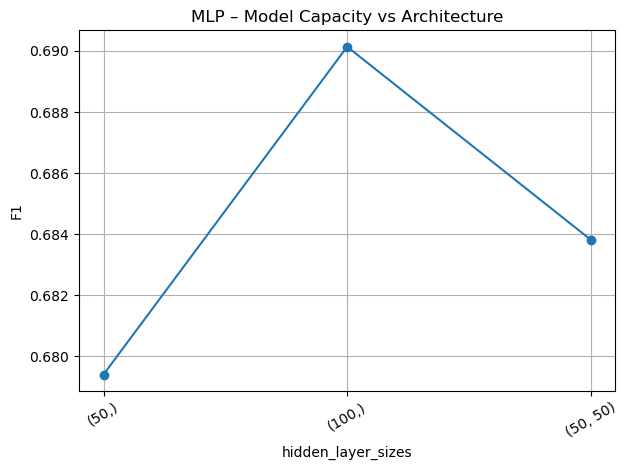

In [32]:
mlp_base = mlp_pipe.set_params(clf__alpha=0.001, clf__learning_rate_init=0.1)

f1_pos = make_scorer(f1_score, pos_label=">50K")

mlp_mc_capacity = model_complexity_curve(
    base_pipeline=mlp_base,
    X=X_train,
    y=y_train,
    param_name="clf__hidden_layer_sizes",
    param_values=[(50,), (100,), (50, 50)],
    scoring=f1_pos
)

plot_mc_curve(mlp_mc_capacity, title="MLP – Model Capacity vs Architecture",xlabel="hidden_layer_sizes")

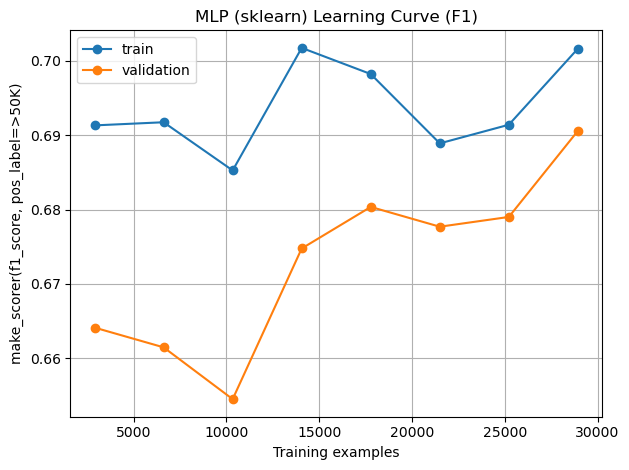

In [33]:
plot_learning_curve(mlp_best, X_train, y_train, "MLP (sklearn) Learning Curve (F1)", scoring=f1_pos)

#### PyTorch + SVD

In [34]:
X_nn_sp = preprocessor.fit_transform(X_train)
X_test_sp = preprocessor.transform(X_test)

X_nn = X_nn_sp.toarray()
X_test_nn = X_test_sp.toarray()

y_nn = (y_train.values == ">50K").astype(int)
y_test_nn = (y_test.values == ">50K").astype(int)


2026-02-08 15:58:43.247551: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


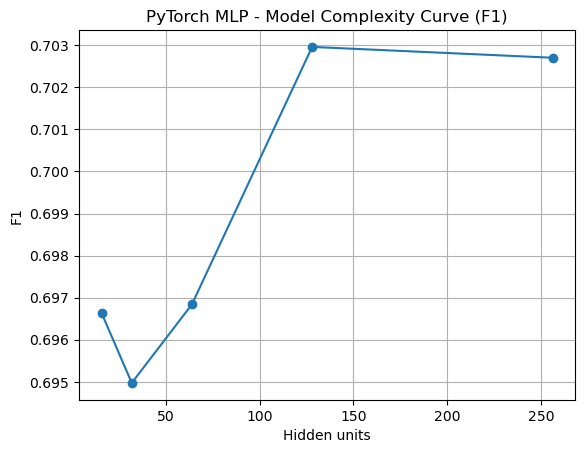

In [36]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

class MLP_tmp(nn.Module):
    def __init__(self, d, h):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d, h),
            nn.ReLU(),
            nn.Linear(h, 2)
        )
    def forward(self, x):
        """
        Forward pass of the neural network
        
        Input: x (torch.Tensor): input batch
        Return: torch.Tensor: output logits
        """
        return self.net(x)

def complexity_curve_pytorch_line(X, y, hidden_values=(16, 32, 64, 128, 256), epochs=10, batch_size=64, lr=0.1, weight_decay=1e-3,
    seed=49):
    """
    Plot a model complexity curve for a PyTorch MLP by varying the number of hidden units while keeping all other hyperparameters fixed
    
    Input:
        X (array): feature matrix 
        y (array): binary target vector
        hidden_values (tuple): list of hidden layer sizes to evaluate
        epochs (int): number of training epochs
        batch_size (int): batch size 
        lr (float): learning rate for SGD optimizer
        weight_decay (float): L2 regularization strength
        seed (int): random seed for reproducibility
    Return: None
    """
    
    torch.manual_seed(seed)
    np.random.seed(seed)

    from sklearn.model_selection import train_test_split
    import matplotlib.pyplot as plt

    X_tr, X_val, y_tr, y_val = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=seed
    )

    val_f1 = []

    for h in hidden_values:
        model = MLP_tmp(X.shape[1], h)
        optimizer = torch.optim.SGD(
            model.parameters(), lr=lr, weight_decay=weight_decay
        )
        criterion = nn.CrossEntropyLoss()

        train_ds = TensorDataset(
            torch.tensor(X_tr, dtype=torch.float32),
            torch.tensor(y_tr, dtype=torch.long)
        )
        val_ds = TensorDataset(
            torch.tensor(X_val, dtype=torch.float32),
            torch.tensor(y_val, dtype=torch.long)
        )

        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
        val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

        for _ in range(epochs):
            model.train()
            for xb, yb in train_loader:
                optimizer.zero_grad()
                loss = criterion(model(xb), yb)
                loss.backward()
                optimizer.step()

        preds, ys = [], []
        model.eval()
        with torch.no_grad():
            for xb, yb in val_loader:
                preds.append(torch.argmax(model(xb), dim=1).numpy())
                ys.append(yb.numpy())

        val_f1.append(f1_score(np.concatenate(ys), np.concatenate(preds)))

    plt.figure()
    plt.plot(hidden_values, val_f1, marker="o")
    plt.xlabel("Hidden units")
    plt.ylabel("F1")
    plt.title("PyTorch MLP - Model Complexity Curve (F1)")
    plt.grid(True)
    plt.show()

complexity_curve_pytorch_line(X_nn, y_nn)

Then, we select 128 hidden units

In [38]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

import gc
gc.collect()

np.random.seed(SEED)
random.seed(SEED)

BATCH_SIZE = 64

train_ds = TensorDataset(
    torch.tensor(X_nn, dtype=torch.float32),
    torch.tensor(y_nn, dtype=torch.long)
)
test_ds = TensorDataset(
    torch.tensor(X_test_nn, dtype=torch.float32),
    torch.tensor(y_test_nn, dtype=torch.long)
)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)


class MLP(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )
    def forward(self, x):
        """
        Forward pass of the neural network

        Input: x (torch.Tensor): input batch
        Return: torch.Tensor: output logits
        """
        return self.net(x)

model = MLP(X_nn.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-3)

for epoch in range(10):  
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()


In [39]:
model.eval()
preds = []
with torch.no_grad():
    for xb, _ in test_loader:
        preds.append(torch.argmax(model(xb), dim=1).numpy())

y_pred_nn = np.concatenate(preds)

print("\nPyTorch MLP (SVD) Results")
print("PyTorch NN Accuracy:", accuracy_score(y_test_nn, y_pred_nn))
print("PyTorch NN F1 (>50K):", f1_score(y_test_nn, y_pred_nn))

cm = confusion_matrix(y_test_nn, y_pred_nn)
print("Confusion Matrix:\n", cm)


PyTorch MLP (SVD) Results
PyTorch NN Accuracy: 0.8493090105030403
PyTorch NN F1 (>50K): 0.6713286713286714
Confusion Matrix:
 [[6290  513]
 [ 850 1392]]


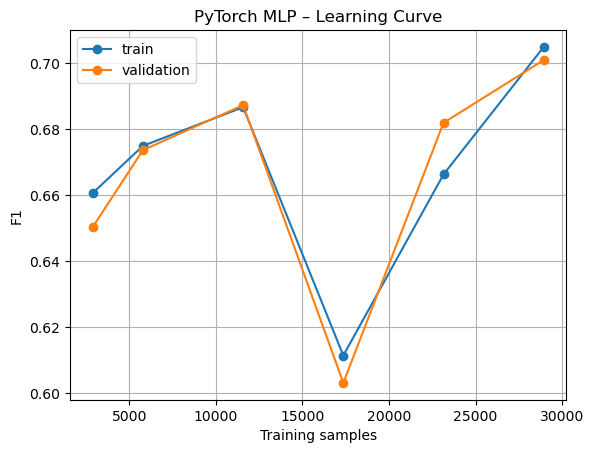

In [44]:
torch.manual_seed(SEED)
np.random.seed(SEED)

def eval_f1_pytorch(model, loader):
    """
    Compute F1 score for a PyTorch model

    Input:
        model (torch.nn.Module): trained neural network model
        loader (DataLoader): DataLoader providing evaluation batches

    Return:
        float: F1 score computed on the provided dataset
    """
    preds, ys = [], []

    model.eval()
    with torch.no_grad():
        for xb, yb in loader:
            preds.append(torch.argmax(model(xb), dim=1).numpy())
            ys.append(yb.numpy())

    return f1_score(np.concatenate(ys), np.concatenate(preds))


def learning_curve_pytorch_line(X, y, train_sizes=(0.1, 0.2, 0.4, 0.6, 0.8, 1.0), hidden_dim=128,epochs=10, batch_size=64, lr=0.1, weight_decay=1e-3, seed=49):
    """
    Plot a learning curve for a PyTorch MLP 

    Input:
        X (array): feature matrix 
        y (array): binary target vector
        train_sizes (tuple): fractions of the training data used for training
        hidden_dim (int): number of hidden units in the MLP
        epochs (int): number of training epochs for each subset
        batch_size (int): batch size used during training
        lr (float): learning rate for SGD optimizer
        weight_decay (float): L2 regularization strength
        seed (int): random seed for reproducibility

    Return: None
    """
    torch.manual_seed(seed)
    np.random.seed(seed)

    X_tr, X_val, y_tr, y_val = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=seed
    )

    train_f1 = []
    val_f1 = []
    sizes = []

    for frac in train_sizes:
        n = int(len(X_tr) * frac)
        X_sub = X_tr[:n]
        y_sub = y_tr[:n]

        train_ds = TensorDataset(
            torch.tensor(X_sub, dtype=torch.float32),
            torch.tensor(y_sub, dtype=torch.long)
        )
        val_ds = TensorDataset(
            torch.tensor(X_val, dtype=torch.float32),
            torch.tensor(y_val, dtype=torch.long)
        )

        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
        val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

        model = MLP(X.shape[1])
        optimizer = torch.optim.SGD(
            model.parameters(), lr=lr, weight_decay=weight_decay
        )
        criterion = nn.CrossEntropyLoss()

        for _ in range(epochs):
            model.train()
            for xb, yb in train_loader:
                optimizer.zero_grad()
                loss = criterion(model(xb), yb)
                loss.backward()
                optimizer.step()

        train_f1.append(eval_f1_pytorch(model, train_loader))
        val_f1.append(eval_f1_pytorch(model, val_loader))
        sizes.append(n)

    plt.figure()
    plt.plot(sizes, train_f1, marker="o", label="train")
    plt.plot(sizes, val_f1, marker="o", label="validation")
    plt.xlabel("Training samples")
    plt.ylabel("F1")
    plt.title("PyTorch MLP – Learning Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

    
learning_curve_pytorch_line(X_nn, y_nn)


In [48]:
rows = []

rows.append({"Model":"Decision Tree", "Accuracy": accuracy_score(y_test, y_pred), "F1-score": f1_score(y_test, y_pred, pos_label=">50K")})

rows.append({"Model":"kNN", "Accuracy": accuracy_score(y_test, y_pred_knn), "F1-score": f1_score(y_test, y_pred_knn, pos_label=">50K")})

rows.append({"Model":"SVM Linear", "Accuracy": accuracy_score(y_test, y_pred_lin), "F1-score": f1_score(y_test, y_pred_lin, pos_label=">50K")})

rows.append({"Model":"SVM RBF", "Accuracy": accuracy_score(y_test, y_pred_svm), "F1-score": f1_score(y_test, y_pred_svm, pos_label=">50K")})

rows.append({"Model":"Neural Network (sklearn)", "Accuracy": accuracy_score(y_test, y_pred_mlp), "F1-score": f1_score(y_test, y_pred_mlp, pos_label=">50K")})

rows.append({"Model":"Neural Network (PyTorch + SVD)", "Accuracy": accuracy_score(y_test_nn, y_pred_nn), "F1-score": f1_score(y_test_nn, y_pred_nn)})


In [49]:
results = pd.DataFrame(rows)

results_sorted = results.sort_values("F1-score", ascending=False)

results_sorted.round(4)

,Model,Accuracy,F1-score
5,Neural Network (PyTorch + SVD),0.8493,0.6713
0,Decision Tree,0.8544,0.6665
4,Neural Network (sklearn),0.8489,0.6614
2,SVM Linear,0.8469,0.6581
3,SVM RBF,0.8488,0.6558
1,kNN,0.8314,0.6308


In [47]:
models_for_runtime = {
    "DT": dt_best,
    "kNN": knn_best,
    "SVM Linear": svm_lin_best,
    "SVM RBF": svm_rbf_best,
    "MLP sklearn": mlp_best,
    
}

runtime_df = build_runtime_table(models_for_runtime, X_train, y_train, X_test, repeats=3)

fit_s_torch, pred_s_torch = torch_runtime_train_predict(
    model, train_loader, test_loader, criterion, optimizer, epochs=10
)


torch_row = pd.DataFrame([{
    "model": "Neural Network (PyTorch)",
    "fit_s": fit_s_torch,
    "predict_s": pred_s_torch
}])

runtime_df_with_torch = pd.concat([runtime_df, torch_row], ignore_index=True)
runtime_df_with_torch.sort_values("fit_s")


,model,fit_s,predict_s
0,kNN,0.138028,2.663147
1,DT,0.573041,0.025506
2,SVM Linear,1.204881,0.024388
3,MLP sklearn,3.733691,0.043194
5,Neural Network (PyTorch),7.372005,0.060288
4,SVM RBF,46.137422,6.323801
